In [1]:
# Import required libraries
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns
import ssl
from ete3 import NCBITaxa

# Configure SSL settings
ssl._create_default_https_context = ssl._create_unverified_context

# Set the directory path
directory_path = '/Users/apple/Desktop/Diversity/'

In [2]:


# Load data from CSV files
microbes_data = pd.read_csv(directory_path + '1. Data_Chng2020.xlsx - Chng_2020.csv',
                            index_col='Species')

group_data = pd.read_csv(directory_path + '1. Data_Chng2020.xlsx - Chng_2020_groups.csv',
                         index_col='Species')

# Load metadata from a CSV file
metadata = pd.read_csv(directory_path + '1. Data_Chng2020.xlsx - Metadata.csv',
                       index_col='Illumina Library ID')


In [3]:
# Display the head of metadata for initial exploration
metadata.head()

,Date of Collection,Surface Material,Site,Location,Environment
Illumina Library ID,,,,,
MEE001,21/05/2019,Metal,Bed Rail,MDRO,Hospital
MEE002,21/05/2019,Metal and wood,Cardiac Table,MDRO,Hospital
MEE003,21/05/2019,Metal,Aerator,MDRO,Hospital
MEE004,21/05/2019,Metal,Sink Trap,MDRO,Hospital
MEE005,21/05/2019,Plastic,Bed Rail,MDRO,Hospital


In [4]:
# Merge 'Major_group' column from 'group_data' into 'microbes_data' based on 'Species'
merged_data = pd.merge(microbes_data, group_data, on='Species', how='left')
merged_data.head()

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388,Major_group
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0,Bacteria
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria


In [5]:
# Count occurrences of microbes in each environment based on 'Major_group'
transposed_data = merged_data.transpose()
data_with_environment = pd.merge(transposed_data, metadata['Environment'],
                                 left_index=True, right_index=True)
filtered_data = data_with_environment[data_with_environment != 0].groupby('Environment').count().transpose().merge(group_data,
                                                                                                               left_index=True,
                                                                                                               right_index=True)
filtered_data.iloc[:, :-1] = filtered_data.iloc[:, :-1].applymap(lambda x: 1 if x != 0 else x)
grouped_data = filtered_data.groupby('Major_group').sum()
grouped_data

,Hospital,MetaSUB,Office
Major_group,,,
Archaea,3,2,0
Bacteria,642,350,179
Fungi,10,2,3
Virus,127,26,4


In [6]:
# Calculate average bacterial abundance by environment
abundance_dict = {}
for group in merged_data['Major_group'].unique():
    if type(group) == str:
        group_data = merged_data[merged_data['Major_group'] == group].sum(axis=0)
        group_df = pd.DataFrame(group_data, columns=['Sum Bacteria Abundance']).rename_axis("Illumina Library ID")
        new_df = pd.merge(group_df, metadata['Environment'], left_index=True, right_index=True).rename_axis("Illumina Library ID")
        average_values = new_df.groupby('Environment')['Sum Bacteria Abundance'].mean().round(2).to_list()
        abundance_dict[group] = average_values

abundance_compiled = pd.DataFrame(abundance_dict, index=metadata['Environment'].unique())
abundance_compiled = abundance_compiled.rename_axis("Environment")
abundance_compiled

,Bacteria,Virus,Fungi,Archaea
Environment,,,,
Hospital,89.15,9.65,1.08,0.01
MetaSUB,97.87,1.87,0.19,0.01
Office,99.57,0.16,0.23,0.00


In [7]:
# Select only bacteria data for box plot
bacteria_data = merged_data[merged_data['Major_group'] == "Bacteria"].sum(axis=0)
bacteria_df = pd.DataFrame(bacteria_data, columns=['Sum Bacteria Abundance']).rename_axis("Illumina Library ID")
aggregated_df = pd.merge(bacteria_df, metadata['Environment'], left_index=True, right_index=True).rename_axis("Illumina Library ID")
aggregated_df

,Sum Bacteria Abundance,Environment
Illumina Library ID,,
MEE001,93.024,Hospital
MEE002,93.52,Hospital
MEE003,99.859,Hospital
MEE004,100.0,Hospital
MEE005,91.529,Hospital
...,...,...
WEE384,82.189,Hospital
WEE385,95.83,Hospital
WEE386,96.544,Hospital


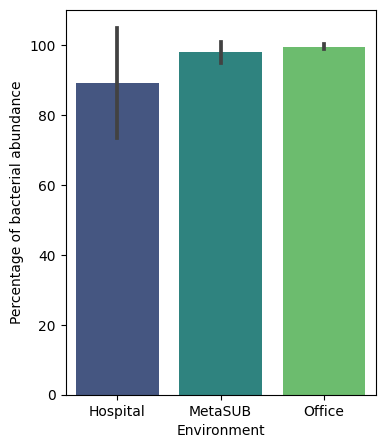

In [8]:
# Bar Plot

plt.figure(figsize=(4, 5))
sns.barplot(x='Environment', y='Sum Bacteria Abundance', data=aggregated_df, order=sorted(aggregated_df['Environment'].unique()), errorbar="sd", palette='viridis')
plt.xlabel('Environment')
plt.ylabel('Percentage of bacterial abundance')
plt.savefig(directory_path + 'bacterial_composition.svg', format='svg')
plt.show()

In [9]:
# Filter data for only bacteria
bacteria_data = merged_data[merged_data['Major_group'] == 'Bacteria']
bacteria_data

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388,Major_group
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0,Bacteria
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas citri,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,2.800,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas euvesicatoria,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.354,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas fuscans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,7.748,0.000,0.000,0.0,0.0,Bacteria


In [10]:
# Load updated names from a CSV file
updated_names = pd.read_csv(directory_path + 'Taxonomic_raw_details - Updated_names.csv', sep=",")

# Convert DataFrame to dictionary
updated_name_dict = updated_names.set_index('Previous name')['Updated name'].to_dict()

# Replace the index names using the updated names dictionary
bacteria_data.index = bacteria_data.index.to_series().replace(updated_name_dict)
bacteria_data

,SL336366,SL336368,SL343330,SL343331,SL343333,SL343334,SL343336,SL343337,SL343339,SL343341,...,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386,WEE387,WEE388,Major_group
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.0,0.0,0.0,0.0,0.0,0.388,0.0,0.0,0.0,0.0,...,0.000,0.0,0.578,0.0,0.129,0.777,0.518,0.0,0.0,Bacteria
Acetobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter piechaudii,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.132,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter unclassified,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
Achromobacter xylosoxidans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,Bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas citri,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,2.800,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas euvesicatoria,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,0.354,0.000,0.000,0.0,0.0,Bacteria
Xanthomonas fuscans,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.0,7.748,0.000,0.000,0.0,0.0,Bacteria


In [11]:
# Function to get taxonomic information for a given bacteria name
def get_taxonomic_info(bacteria_name):
    try:
        ncbi = NCBITaxa()
        taxid_mapping = ncbi.get_name_translator([bacteria_name])

        if not taxid_mapping:
            return {"Taxonomic_ID": "not found"}

        tax_id = taxid_mapping[bacteria_name][0]
        lineage = ncbi.get_lineage(tax_id)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.get_taxid_translator(lineage)

        result = {"Taxonomic_ID": tax_id}
        result.update({ranks[tid]: names[tid] for tid in lineage})

        return result

    except Exception as e:
        return {"Error": str(e)}

In [12]:
# Apply the function to create a new column 'Taxonomic_Info'
bacteria_data["Taxonomic_Info"] = bacteria_data.index.map(get_taxonomic_info)
result_df = pd.json_normalize(bacteria_data["Taxonomic_Info"]).fillna("not found")
result_df.index = bacteria_data.index
result_df

/var/folders/q6/tnzbv86d4m77k36qb17p7kth0000gr/T/ipykernel_11462/54611467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data["Taxonomic_Info"] = bacteria_data.index.map(get_taxonomic_info)


,Taxonomic_ID,no rank,superkingdom,clade,phylum,class,order,family,genus,species,species group,species subgroup,suborder,strain,subclass,tribe,subspecies
Species,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,46125,cellular organisms,Bacteria,Terrabacteria group,Bacillota,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,not found,not found,not found,not found,not found,not found,not found
Acetobacter unclassified,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found
Achromobacter piechaudii,72556,cellular organisms,Bacteria,not found,Pseudomonadota,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter piechaudii,not found,not found,not found,not found,not found,not found,not found
Achromobacter unclassified,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found,not found
Achromobacter xylosoxidans,85698,cellular organisms,Bacteria,not found,Pseudomonadota,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter xylosoxidans,not found,not found,not found,not found,not found,not found,not found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthomonas citri,346,cellular organisms,Bacteria,not found,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas citri,Xanthomonas citri group,not found,not found,not found,not found,not found,not found
Xanthomonas euvesicatoria,456327,cellular organisms,Bacteria,not found,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas euvesicatoria,not found,not found,not found,not found,not found,not found,not found
Xanthomonas fuscans,366649,Xanthomonas citri pv. fuscans,Bacteria,not found,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas citri,Xanthomonas citri group,not found,not found,not found,not found,not found,not found


In [13]:
# Filter taxa table for only valid taxonomic IDs
filtered_taxa_table = result_df[result_df['Taxonomic_ID'] != 'not found']
filtered_taxa_table

# Filter samples data based on valid taxonomic IDs
filtered_samples_data = bacteria_data.loc[bacteria_data.index.isin(filtered_taxa_table.index)]
filtered_samples_data = filtered_samples_data.drop(columns=["Major_group", "Taxonomic_Info"], axis=1)
filtered_samples_data = filtered_samples_data / 100
filtered_samples_data

# Filter metadata based on valid samples
metadata_filtered = metadata.loc[metadata.index.isin(filtered_samples_data.columns)]
metadata_filtered

# Save filtered data, taxa, and metadata to CSV files
filtered_samples_data.to_csv(directory_path + "Network/all_filtered_data.csv", index=True, sep=',')
filtered_taxa_table.to_csv(directory_path + "Network/all_filtered_taxa.csv", index=True, sep=',')
metadata_filtered.to_csv(directory_path + "Network/all_filtered_metadata.csv", index=True, sep=',')

In [14]:
# Process and save data, taxa, and metadata for each environment
df_dict, taxa_dict, metadata_dict = {}, {}, {}
for env in metadata["Environment"].unique():
    sample_list = metadata[metadata["Environment"] == env].index.to_list()
    subset_df = filtered_samples_data[filtered_samples_data.columns[filtered_samples_data.columns.isin(sample_list)]]

    # Keep only non-zero rows
    subset_df = subset_df[(subset_df.sum(axis=1)) != 0]
    subset_df = subset_df.loc[:, (subset_df.sum(axis=0) != 0)]

    # Keep rows with a count of non-zero entries greater than the threshold
    subset_df = subset_df[(subset_df > 0).sum(axis=1) >= (0.1 * len(subset_df.columns))]

    # Keep rows with relative abundance greater than 1%
    subset_df = subset_df[(subset_df >= .01).any(axis=1)]

    taxa_df = filtered_taxa_table.loc[filtered_taxa_table.index.isin(subset_df.index)]
    metadata_df = metadata.loc[metadata.index.isin(subset_df.columns)]
    df_dict[env] = subset_df
    taxa_dict[env] = taxa_df
    metadata_dict[env] = metadata_df

    subset_df.to_csv(f"{directory_path}Network/{env}_filtered_data.csv", index=True, sep=',')
    taxa_df.to_csv(f"{directory_path}Network/{env}_filtered_taxa.csv", index=True, sep=',')
    metadata_df.to_csv(f"{directory_path}Network/{env}_filtered_metadata.csv", index=True, sep=',')

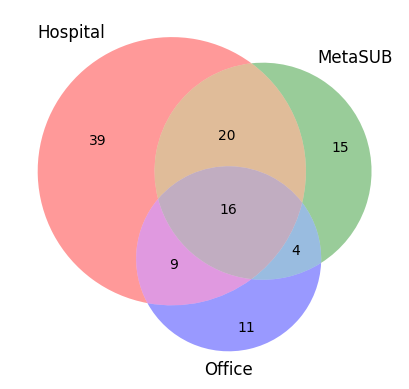

In [15]:
# Get the sets of taxa for the Venn diagram
taxa_sets = {key: set(value.index) for key, value in taxa_dict.items()}
venn3([taxa_sets['Hospital'], taxa_sets['MetaSUB'], taxa_sets['Office']], set_labels=['Hospital', 'MetaSUB', 'Office'])

# Save the plot
plt.savefig(directory_path + 'taxa_venn_diagram.svg', format='svg')
plt.show()

/var/folders/q6/tnzbv86d4m77k36qb17p7kth0000gr/T/ipykernel_11462/2390712967.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1
/var/folders/q6/tnzbv86d4m77k36qb17p7kth0000gr/T/ipykernel_11462/2390712967.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1
/var/folders/q6/tnzbv86d4m77k36qb17p7kth0000gr/T/ipykernel_11462/2390712967.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_taxa_binary.loc[values, key] = 1


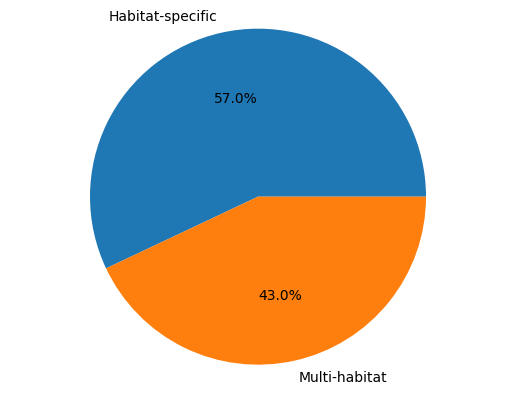

In [16]:
# Create a list of all unique values from taxa_sets
unique_values = sorted(list(set().union(*taxa_sets.values())))

# Create an empty DataFrame with unique values as index and keys as columns
df_taxa_binary = pd.DataFrame(0, index=unique_values, columns=sorted(taxa_sets.keys()))

# Fill the DataFrame with 1 for present values
for key, values in taxa_sets.items():
    df_taxa_binary.loc[values, key] = 1

df_taxa_binary.to_csv(directory_path + 'taxa_binary.csv', index=True, sep=',')
df_taxa_binary

# Calculate the row sum of the DataFrame
row_sum = df_taxa_binary.sum(axis=1)

# Classify index values as habitat-specific or multi-habitat
classification = ['Habitat-specific' if val == 1 else 'Multi-habitat' for val in row_sum]

# Count the number of occurrences for each classification
classification_counts = pd.Series(classification).value_counts()

# Create a pie chart
plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.savefig(directory_path + 'taxa_classification_pie_chart.svg', format='svg')
plt.show()